# 月线多头

寻找月线多头

In [386]:
import jqdatasdk as jq
import os
import arrow
import datetime
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics.pairwise import paired_distances
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
from alpha.notebook import *

account = os.getenv("JQ_ACCOUNT")
password = os.getenv("JQ_PASSWORD")

jq.auth(account, password)
valuations=jq.get_fundamentals(query(valuation))
secs = jq.get_all_securities()

def get_name(code):
    return secs[secs.index==code].iloc[0]["display_name"]

def get_code(name):
    return secs[secs.display_name.str.find(name.upper())!=-1].index.tolist()[0]

def get_valuation(code):
    return int(valuations[valuations.code==code].iloc[0]["market_cap"])

def choose_stocks(exclude_st=True, exclude_688=True, valuation_range=(100,2000)):
    result = secs
    if exclude_688:
        result = result[result.index.str.startswith("688")==False]
    if exclude_st:
        result = result[result.display_name.str.find("ST") == -1]
        
    codes = []
    for code in result.index:
        try:
            if valuation_range[0] <= get_valuation(code) <= valuation_range[1]:
                codes.append(code)
        except Exception:
            pass
            
    return codes

def top_n_argpos(ts: np.array, n: int) -> np.array:
    """get top n (max->min) elements and return argpos which its value ordered in descent

    Example:
        >>> top_n_argpos([4, 3, 9, 8, 5, 2, 1, 0, 6, 7], 2)
        array([2, 3])
    Args:
        ts (np.array): [description]
        n (int): [description]

    Returns:
        np.array: [description]
    """
    return np.argsort(ts)[-n:][::-1]

def moving_average(ts: np.array, win: int):
    """计算时间序列ts在win窗口内的移动平均

    Example:

        >>> ts = np.arange(7)
        >>> moving_average(ts, 5)
        >>> array([2.0000, 3.0000, 4.0000])

    """

    return np.convolve(ts, np.ones(win) / win, "valid")

def get_bars(code, n, end, unit='1d'):
    fields = ["date", "open", "high", "low", "close", "volume"]
    return jq.get_bars(code, n, unit=unit, end_dt=end, fq_ref_date=end, df=False, include_now=True, fields=fields)

def predict_by_moving_average(
    ts, win: int, n_preds: int = 1, err_threshold=1e-2, n:int=None
) -> float:
    """predict the next ith value by fitted moving average

    make sure ts is not too long and not too short

    Args:
        ts (np.array): the time series
        i (int): the index of the value to be predicted, start from 1
        win (int): the window size
        n (int): how many ma sample points used to polyfit the ma line

    Returns:
        float: the predicted value
    """
    ma = moving_average(ts, win)

    # how many ma values used to fit the trendline?
    if n is None:
        n = {5: 7, 10: 10}.get(win, 15)

    if len(ma) < n:
        raise ValueError(f"{len(ma)} < {n}, can't predict")

    coef, pmae = polyfit(ma[-n:], degree=2)
    if pmae > err_threshold:
        return None, None

    # build the trendline with same length as ma
    fitma = np.polyval(coef, np.arange(n - len(ma), n + n_preds))

    preds = [
        reverse_moving_average(fitma[: i + 1], i, win)
        for i in range(len(ma), len(ma) + n_preds)
    ]

    return preds, pmae

def polyfit(ts: np.array, degree: int = 2) -> tuple:
    """fit ts with np.polyfit, return coeff and pmae"""
    coeff = np.polyfit(np.arange(len(ts)), ts, degree)
    pmae = np.abs(np.polyval(coeff, np.arange(len(ts))) - ts).mean() / np.mean(ts)
    return coeff.tolist(), pmae


def reverse_moving_average(ma, i: int, win: int) -> float:
    """given moving_average, reverse the origin value at index i

    if i < win, then return Nan, these values are not in the window thus cannot be recovered

    see also https://stackoverflow.com/questions/52456267/how-to-do-a-reverse-moving-average-in-pandas-rolling-mean-operation-on-pr
    but these func doesn't perfom well with out moving_average
    Example:
        >>> c = np.arange(10)
        >>> ma = moving_average(c, 3)
        >>> c1 = [reverse_moving_average(ma, i, 3) for i in range(len(ma))]
        >>> c1 == [1, 2, 3, 4.9999, 6.000, 7, 8, 9]

    Args:
        ma (np.array): the moving average series
        i (int): the index of origin
        win (int): the window size, which is used to calculate moving average
    """
    return ma[i] * win - ma[i - 1] * win + np.mean(ma[i - win : i])

def load_monthly_bars():
    with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
        return pickle.load(f)

In [2]:
def scan(end:str=None):
    """通过月均线预测下一个月涨幅"""
    if end is None:
        end = arrow.now().date()
    else:
        end = arrow.get(end).date()
        
    results = []
    nbars = 29
    for i, code in enumerate(choose_stocks(50, 1000)):
        name = get_name(code)
        bars = get_bars(code, nbars, end, unit='1M')
        
        if len(bars) < nbars:
            continue
            
        close = bars["close"]
        c0 = close[-1]
        max_pcr = 0
        
        mas = []
        for win in [5, 10, 20]:
            ma = moving_average(close, win)[-1]
            mas.append(ma)
            
            ypreds, pmae = predict_by_moving_average(close, win, n=10)
            if ypreds is None:
                continue
                
            pcr = max(ypreds) / c0 - 1
            max_pcr = max(pcr, max_pcr)
        
        if max_pcr < 0.1:
            continue
            
        if mas[0] >= mas[1] >= mas[2]:
            row = [name, code, max_pcr]
            row.extend(mas)
            results.append(row)

    return pd.DataFrame(results, columns=["股票", "代码", "预测涨幅", "ma5", "ma10", "ma20"])

In [ ]:
df = scan()
df.style.format({
    "预测涨幅": "{:.0%}"
})

In [ ]:
df.sort_values("预测涨幅", ascending=False)

# 相似均线拟合法

In [35]:
# 给定时间点和代码，生成拟合均线。再scan所有股票和所有时间点，将欧氏距离和实际涨幅分别作为x,y

def build_sample_line(code, frame:str, ma_groups=(5, 10, 20)):
    line_len = 7
    nbars = max(ma_groups) + line_len - 1
    bars = get_bars(code, nbars, frame, unit="1M")
    
    x = np.arange(line_len)
    
    vec = []
    dist = {}
    for win in ma_groups:
        ma = moving_average(bars["close"], win)[-line_len:]
        ma /= ma[0]
        coeff, pmae = polyfit(ma)
        vec.append(np.polyval(coeff, x))
        
    return vec

jl = build_sample_line("002791.XSHE", "2019-12-31")
jl

[array([1.01196081, 1.03484548, 1.08812264, 1.17179228, 1.28585442,
        1.43030903, 1.60515614]),
 array([0.99989306, 1.04790797, 1.11745669, 1.20853923, 1.3211556 ,
        1.45530578, 1.61098979]),
 array([1.00294756, 0.98767367, 0.98656675, 0.99962678, 1.02685378,
        1.06824775, 1.12380868])]

## 坚朗五金月线拟合

In [46]:
def search_jl(sample_lines, line_len=7, ma_groups=(5, 10, 20)):
    nbars = max(ma_groups) + line_len - 1
    results = []
    
    x = np.arange(line_len)
    threshold = {
        5: 0.03,
        10: 0.025,
        20:0.01
    }
    for code, bars in load_monthly_bars().items():
        for i in range(nbars, len(bars) - 1):
            bars_ = bars[i-nbars: i]
            
            frame = bars_['date'][-1]
            close = bars_['close']
            
            c0 = close[-1]
            c1 = bars["close"][i]
            
            pcr = c1/c0 - 1

            row = [code, get_name(code), frame, pcr]
            mas = []
            for win in ma_groups:
                ma = moving_average(close, win)[-line_len:]
                ma /= ma[0]
                mas.append(ma)

            
            distances = paired_distances(sample_lines, mas)
            row.extend(distances)

            results.append(row)
            
    return pd.DataFrame(results, columns=["code", "name", "frame", "pcr", "d5", "d10", "d20"])

jl = build_sample_line("002791.XSHE", "2019-12-31")
df_jl = search_jl(jl)
df_jl

,code,name,frame,pcr,d5,d10,d20
0,000001.XSHE,平安银行,2018-02-28,-0.095986,0.332007,0.535052,0.120371
1,000001.XSHE,平安银行,2018-03-30,-0.004826,0.412514,0.512053,0.135537
2,000001.XSHE,平安银行,2018-04-27,-0.061106,0.541735,0.524748,0.136592
3,000001.XSHE,平安银行,2018-05-31,-0.107438,0.738338,0.594178,0.122654
4,000001.XSHE,平安银行,2018-06-29,0.052083,0.920721,0.679874,0.111317
...,...,...,...,...,...,...,...
134047,603999.XSHG,读者传媒,2021-02-26,0.007874,0.937810,1.009788,0.149231
134048,603999.XSHG,读者传媒,2021-03-31,-0.015625,0.993823,1.014437,0.163885
134049,603999.XSHG,读者传媒,2021-04-30,0.132937,1.052503,0.983871,0.166475
134050,603999.XSHG,读者传媒,2021-05-31,-0.085814,1.109284,0.968252,0.168404


In [47]:
df_jl[df_jl.d5<0.05]

,code,name,frame,pcr,d5,d10,d20
2866,000157.XSHE,中联重科,2021-03-31,-0.071020,0.047535,0.281168,0.326099
10908,000708.XSHE,中信特钢,2019-12-31,-0.067877,0.034391,0.120660,0.187678
12064,000748.XSHE,长城信息,2015-02-27,0.144368,0.049932,0.249988,0.683716
21589,002050.XSHE,三花智控,2020-02-28,-0.191304,0.044134,0.396129,0.047266
32255,002311.XSHE,海大集团,2020-08-31,-0.133390,0.045720,0.350900,0.358054
33452,002340.XSHE,格林美,2021-04-30,0.126126,0.042371,0.430425,0.136470
33937,002352.XSHE,顺丰控股,2020-09-30,0.019681,0.033829,0.348838,0.153156
40454,002511.XSHE,中顺洁柔,2020-07-31,0.004523,0.027499,0.370781,0.310090
51561,002791.XSHE,坚朗五金,2019-12-31,0.372652,0.028337,0.022275,0.008794
53959,002880.XSHE,卫光生物,2020-07-31,-0.154772,0.028257,0.275153,0.193937


## 鸿路钢构

In [ ]:
mas_hl = {}

hl = get_bars('002541.XSHE', 29, '2020-01-23', unit='1M')
print(bars['date'][-3:])
for win in [5, 10, 20]:
    ma = moving_average(bars['close'], win)[-10:]
    ma /= ma[0]
    coeff, pmae = polyfit(ma)
    
    fitma = np.polyval(coeff, x)
    mas_hl[win] = fitma
mas_hl

In [ ]:
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances

x = np.arange(10)

colors = {
    5: 'r',
    10:'g',
    20:'blue'
}
for win in [5, 10, 20]:
    ma_hl = mas_hl[win]
    ma_jl = mas_jl[win]
    
    d = euclidean_distances([ma_hl], [ma_jl])
    print(d)
    
    plt.plot(x, ma_hl, ".", color=colors[win])
    plt.plot(x, ma_jl, "-", color=colors[win])

In [ ]:
secs[secs.start_date < datetime.datetime(2018,1,1,0,0,0)]

# 机器学习方法

In [2]:
import pickle
def make_ds_month(path):
    end = arrow.get("2021-08-31").date()
    data = {}
    for code in secs[secs.start_date < datetime.datetime(2018,1,1,0,0,0)].index:
        bars = get_bars(code, 68, end, unit='1M')
        data[code] = bars
        
    path = os.path.expanduser(path)
    with open(path, "wb") as f:
        pickle.dump(data, f, protocol=5)

In [3]:
   
def search():
    results = []
    pred_samples = {
        5: 7,
        10: 10,
        20: 10
    }
    for code, bars in load_monthly_bars().items():
        for i in range(29, len(bars) - 1):
            bars_ = bars[i-29: i]
            
            frame = bars_['date'][-1]
            c0 = bars_['close'][-1]
            c1 = bars[i]['close']
            pcr = c1/c0 - 1

            row = [code, get_name(code), frame, pcr]
            for win in [5, 10, 20]:
                ma = moving_average(bars_['close'], win)[-10:]
                ma /= ma[0]
                (a,b,c), pmae = polyfit(ma)
                
                ypreds, _ = predict_by_moving_average(bars_['close'], win, 1, 1, pred_samples[win])
                if ypreds is not None:
                    pred = ypreds[0] / c0 - 1
                else:
                    pred = None
                    
                row.extend((a, b, pmae, pred))

            results.append(row)
                        
    return pd.DataFrame(results, columns=["code", "name", "frame", "actual", "a5", "b5", "pmae5", "pred5",
                                         "a10", "b10", "pmae10", "pred10",
                                         "a20", "b20", "pmae20", "pred20"])
            
df = search()

In [4]:
def preprocess(df):
    """prepare dataset for xgboost classification
    
    0 不可预测
    1 可用5月线预测
    2 可用10月线
    3 可用20月线
    """
    return {
        "X": df[["a5", "b5", "pmae5", "pred5",
                "a10", "b10", "pmae10", "pred10",
                "a20", "b20", "pmae20", "pred20"]],
        
        "y": labelling(df)
    }


In [5]:
def labelling(df, threshold=0.1):
    """"""
    labels = []
    for i in range(len(df)):
        pred5 = df.loc[i, "pred5"]
        pred10 = df.loc[i, "pred10"]
        pred20 = df.loc[i, "pred20"]
        actual = df.loc[i, "actual"]
        
        d = np.abs(np.array([pred5 - actual, pred10 - actual, pred20 - actual]))
        if min(d) > threshold:
            labels.append(0)
            continue
            
        pos = np.argmin(d)
        labels.append(pos + 1)
        
    return labels

In [ ]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform


def train(X_train, y_train, X_test, y_test):
    model = XGBClassifier()
    
    params = {
            "colsample_bytree": uniform(0.7, 0.3),
            "gamma": uniform(0, 0.5),
            "learning_rate": uniform(0.01, 1),
            "max_depth": randint(2, 6),
            "n_estimators": randint(80, 150),
            "subsample": uniform(0.6, 0.4),
        }
    
    search = RandomizedSearchCV(
        model,
        param_distributions=params,
        random_state=78,
        n_iter=200,
        cv=10,
        verbose=1,
        n_jobs=1,
        return_train_score=True,
        refit=True,  # do the refit oursel
    )
    
    fit_params = {
            "eval_set": [(X_test, y_test)],
            "early_stopping_rounds": 5,
        }
    
    search.fit(X_train, y_train, **fit_params)
    
    best_model = search.best_estimator_
    preds = best_model.predict(X_test)
    report = classification_report(y_test, preds)
    print(report)
    
data = preprocess(df)
X, y = shuffle(data["X"], data["y"], random_state=78)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
train(X_train, y_train, X_test, y_test)

# 拟合均线预测法

在a5, a10, a20, a30都大于0的情况下，预测下一个月的涨幅。当拟合线与实际ma误差小于0.01时，认为拟合有效。

In [48]:
class NotFitableError(Exception):
    pass

class NotProfitableError(Exception):
    pass

def scan(fit_err=0.01):
    with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
        data = pickle.load(f)
        
    results = []
    for code, bars in data.items():
        name = get_name(code)
        
        for i in range(39, len(bars)-2):
            frame = bars["date"][i-1]
            close = bars["close"][i - 39: i]
            pcr = max(bars["close"][i:i+2])/close[-1] - 1
            max_pcr_pred = 0

            row = [name, code, frame, pcr]
            try:
                for win in [5, 10, 20, 30]:
                    fit_win = 7 if win == 5 else 10
                    ma = moving_average(close, win)[-fit_win:]
                    ma /= ma[0]
                            
                    coeff, pmae = polyfit(ma)
                    a, b, _ = coeff
                    
                    row.extend((a, b))
                    ma_fit = np.polyval(coeff, np.arange(fit_win))
                    d = euclidean_distances([ma_fit], [ma]).flatten()[0]
                    
                    if d > fit_err: # 当前均线没有指示意义
                        continue
                    
                    ypreds, _ = predict_by_moving_average(close, win, 2, err_threshold=1, n=fit_win)
                    if ypreds is not None:
                        pcr_pred = ypreds[-1] / close[-1] - 1
                        # 如果当前均线指示会有较大跌幅
                        if pcr_pred < 0 and abs(pcr_pred) > max(max_pcr_pred, 0.2):
                            raise NotProfitableError
                            
                        max_pcr_pred = max(max_pcr_pred, pcr_pred)
                        
                row.append(max_pcr_pred)
                results.append(row)
            except (NotFitableError, NotProfitableError):
                pass
            
    return pd.DataFrame(results, columns=["name", "code", "frame", "pcr", "a5", "b5", 
                                          "a10", "b10", "a20", "b20", "a30", "b30", "pred"])
        

In [49]:
df = scan(0.005)
df

,name,code,frame,pcr,a5,b5,a10,b10,a20,b20,a30,b30,pred
0,平安银行,000001.XSHE,2019-03-29,0.080841,0.001589,0.010246,0.002157,-0.030928,0.000464,0.003837,0.000148,0.006306,0.000000
1,平安银行,000001.XSHE,2019-04-30,0.005236,0.004915,-0.002852,0.003967,-0.041288,0.000450,0.005044,0.000409,0.004807,0.000000
2,平安银行,000001.XSHE,2019-05-31,0.171769,0.006446,-0.004358,0.004961,-0.043349,0.000362,0.006196,0.000576,0.003899,0.000000
3,平安银行,000001.XSHE,2019-06-28,0.027530,0.004595,0.016754,0.005082,-0.036298,0.000332,0.006782,0.000744,0.003336,0.000000
4,平安银行,000001.XSHE,2019-07-31,0.103774,0.001420,0.039597,0.004232,-0.020538,0.000082,0.009125,0.000819,0.003902,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79849,读者传媒,603999.XSHG,2021-01-29,0.019920,-0.008087,0.043065,-0.002601,0.018671,-0.001311,0.018172,0.000297,-0.008336,0.000000
79850,读者传媒,603999.XSHG,2021-02-26,0.007874,-0.006086,0.019196,-0.002085,0.010938,-0.001599,0.018723,0.000201,-0.006779,0.000000
79851,读者传媒,603999.XSHG,2021-03-31,0.115234,-0.003325,-0.003286,-0.001095,-0.000508,-0.001392,0.014552,0.000274,-0.006816,0.000000
79852,读者传媒,603999.XSHG,2021-04-30,0.132937,-0.000952,-0.023100,0.000042,-0.012780,-0.000917,0.007973,0.000475,-0.007959,0.000000


In [50]:
pred = df[df.pred!=0]
pred["gap"] = pred.pred - pred.pcr

/var/folders/b5/73vzvtdn4pn_8wt6rpd2tb_w0000gn/T/ipykernel_92887/3240071474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred["gap"] = pred.pred - pred.pcr


In [52]:
pred.gap.describe()

count    5793.000000
mean        0.119829
std         0.201467
min        -2.131919
25%         0.029443
50%         0.120081
75%         0.223297
max         1.495250
Name: gap, dtype: float64

In [487]:
pd.set_option('display.max_rows', 500)
pred[(pred.code=="000422.XSHE")]

,name,code,frame,pcr,a5,b5,a10,b10,a20,b20,a30,b30,pred,gap
2343,湖北宜化,000422.XSHE,2019-11-29,0.050725,0.001076,-0.052717,-0.004565,0.053913,0.002297,-0.041769,-0.000050,-0.027675,0.581643,0.530919
2344,湖北宜化,000422.XSHE,2019-12-31,-0.058621,0.007428,-0.086234,-0.003121,0.031028,0.002534,-0.039848,0.000682,-0.034634,0.627796,0.686417
2345,湖北宜化,000422.XSHE,2020-01-23,-0.036630,0.009162,-0.085617,-0.002885,0.020433,0.002655,-0.036466,0.000813,-0.035976,0.823688,0.860318
2355,湖北宜化,000422.XSHE,2020-11-30,0.081081,0.002627,-0.014833,0.001056,-0.019601,-0.001028,0.001572,0.002182,-0.031480,0.474015,0.392934
2356,湖北宜化,000422.XSHE,2020-12-31,0.171875,0.005125,-0.020424,0.001514,-0.020096,-0.001167,0.001052,0.002201,-0.027292,0.475655,0.303780


# 湖北宜化相似曲线方法

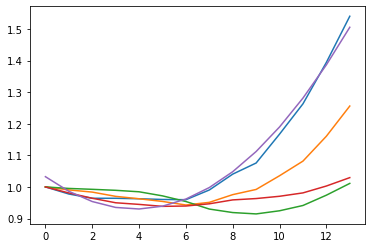

In [92]:
import matplotlib.pyplot as plt

lines = []

# till 2021-05-31
hbyh = data["000422.XSHE"][:-3]
for win in [5, 10, 20, 30]:
    line = moving_average(hbyh["close"], win)[-14:]
    line /= line[0]
    lines.append(line.tolist())
    
hbyh_vec = np.array(lines, dtype=np.float32)
for vec in hbyh_vec:
    plt.plot(vec)
    
coeff, pmae = polyfit(lines[0])
yfit = np.polyval(coeff, np.arange(0, 14))
plt.plot(yfit)

In [101]:
class NotEnoughDataError(Exception):
    pass
def search_like_hbyh():
    results = []
    for code, bars in data.items():
        name = get_name(code)
        for i in range(43, len(bars)-2):
            frame = bars["date"][i-1]
            close = bars["close"][i-43:i]
            pcr = max(bars["close"][i:i+2])/close[-1] - 1
            
            row_result = [name, code, frame, pcr]
            lines = []
            try:
                for win in [5, 10, 20, 30]:
                    line = moving_average(close, win)[-14:]
                    if len(line) != 14:
                        raise NotEnoughDataError
                    line /= line[0]

                    lines.append(line.tolist())
            except NotEnoughDataError:
                pass
                
            d = paired_distances(hbyh_vec, lines)
            row_result.extend(d)
            results.append(row_result)
            
    return pd.DataFrame(results, columns=["name", "code", "frame", "pcr", "d5", "d10", "d20", "d30"])
df = search_like_hbyh()            

In [113]:
thres = 0.15
df[(df.d5<thres) & (df.d10 < thres) & (df.d20<thres) &(df.d30<thres)]

,name,code,frame,pcr,d5,d10,d20,d30
1696,东方盛虹,000301.XSHE,2020-12-31,0.497877,1.231754e-01,6.399010e-02,9.550783e-02,1.447272e-01
2184,湖北宜化,000422.XSHE,2021-05-31,0.788350,9.741137e-08,8.989241e-08,6.394054e-08,7.930420e-08
38590,斯莱克,300382.XSHE,2020-09-30,0.055085,1.252443e-01,8.222057e-02,1.404696e-01,1.400761e-01
38955,飞凯材料,300398.XSHE,2020-06-30,0.145437,1.270039e-01,9.420443e-02,9.965846e-02,7.895171e-02


In [114]:
df["dsum"] = df.d5+df.d10+df.d20+df.d30
df.nsmallest(10, "dsum")

,name,code,frame,pcr,d5,d10,d20,d30,dsum
2184,湖北宜化,000422.XSHE,2021-05-31,0.788350,9.741137e-08,8.989241e-08,6.394054e-08,7.930420e-08,3.305485e-07
44988,云天化,600096.XSHG,2021-05-31,0.456979,6.481235e-02,8.718531e-02,1.694591e-01,4.375146e-02,3.652082e-01
38955,飞凯材料,300398.XSHE,2020-06-30,0.145437,1.270039e-01,9.420443e-02,9.965846e-02,7.895171e-02,3.998185e-01
60706,妙可蓝多,600882.XSHG,2019-09-30,-0.122251,1.636305e-01,5.081940e-02,8.874560e-02,1.133031e-01,4.164986e-01
1696,东方盛虹,000301.XSHE,2020-12-31,0.497877,1.231754e-01,6.399010e-02,9.550783e-02,1.447272e-01,4.274006e-01
52797,方大特钢,600507.XSHG,2021-05-31,-0.048447,2.025826e-01,7.587122e-02,3.816983e-02,1.336984e-01,4.503221e-01
51622,冠豪高新,600433.XSHG,2021-03-31,0.021956,1.536283e-01,6.907507e-02,7.682694e-02,1.713015e-01,4.708318e-01
63412,桐昆股份,601233.XSHG,2021-02-26,-0.106007,8.439427e-02,5.765110e-02,2.122877e-01,1.234266e-01,4.777596e-01
38590,斯莱克,300382.XSHE,2020-09-30,0.055085,1.252443e-01,8.222057e-02,1.404696e-01,1.400761e-01,4.880106e-01
64807,中海油服,601808.XSHG,2019-12-31,-0.142781,1.837877e-01,1.348183e-01,6.839026e-02,1.049272e-01,4.919234e-01


# 股价走势法
直接使用涨跌幅，再求相似曲线。结果不佳

In [134]:
lines = []

# till 2021-05-31
hbyh = data["000422.XSHE"][-52:-3]

close = hbyh["close"]
hbyh_pcr = close[1:]/close[:-1] - 1

In [135]:
def search_like_hbyh_pcr():
    results = []
    for code, bars in data.items():
        name = get_name(code)
        for i in range(49, len(bars)-2):
            frame = bars["date"][i-1]
            close = bars["close"][i-49:i]
            
            pcrs = close[1:]/close[:-1] - 1
            pcr = max(bars["close"][i:i+2])/close[-1] - 1
            
            row_result = [name, code, frame, pcr]
            
            d = euclidean_distances([pcrs], [hbyh_pcr]).flatten()[0]
            row_result.append(d)
            results.append(row_result)
        
    return pd.DataFrame(results, columns=["name", "code", "frame", "pcr", "d"])

df = search_like_hbyh_pcr()

In [136]:
df.nsmallest(10, "d")

,name,code,frame,pcr,d
1614,湖北宜化,000422.XSHE,2021-05-31,0.788350,0.000000
4481,*ST双环,000707.XSHE,2021-05-31,1.011538,0.544890
4838,四川美丰,000731.XSHE,2021-05-31,0.178439,0.583166
3676,英力特,000635.XSHE,2021-05-31,-0.007011,0.626969
31534,四川路桥,600039.XSHG,2021-05-31,-0.125180,0.628701
31840,冠城大通,600067.XSHG,2021-05-31,0.049853,0.641148
32486,重庆路桥,600106.XSHG,2021-05-31,-0.023346,0.647036
7711,桂林旅游,000978.XSHE,2021-05-31,-0.059006,0.652838
31466,楚天高速,600035.XSHG,2021-05-31,0.023891,0.654779
5280,新兴铸管,000778.XSHE,2021-05-31,0.060209,0.658641


# 参考库

In [204]:
pool = []
cm = {
    5: "b",
    10: "g",
    20: "c",
    30: "m",
    60: "y",
    120: "tab:orange",
    "raw": "tab:gray",
}

In [252]:
# 找出两个月内涨幅超过50%的所有个股

with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
    data = pickle.load(f)
    
def find_bulls(adv=0.5):
    results = []
    ma_groups = [5, 10, 20, 30]
    samples = 14
    n = max(ma_groups) + samples - 1
    ylen=5
    
    for code, bars in data.items():
        name = get_name(code)
#         if code != "600084.XSHG":
#             continue
            
        if len(bars) < n:
            continue

        for i in range(n, len(bars) - ylen):
            xbars = bars[i-n:i].copy()
            ybars = bars[i:i+ylen].copy()
            
            frame = xbars["date"][-1]
            xclose = xbars["close"]
            yclose = ybars["close"]
            
            pcr = max(yclose) / xclose[-1] - 1
            
            if pcr < adv:
                continue

            results.append((name, code, frame, pcr))
            
            fig, ax = plt.subplots(nrows=1, ncols=1)

            xclose /= xclose[0]
            
            for win in [5, 10, 20, 30]:
                ma = moving_average(xclose, win)[-samples:]
                ax.plot(ma, color=cm[win])
                
                
            fig.savefig(f'/tmp/find_bulls/{name}-{frame}-{pcr:.2f}.png')
            plt.close(fig)

    df = pd.DataFrame(results, columns=["name", "code", "frame", "pcr"])
    return df
find_bulls(adv=2)

,name,code,frame,pcr
0,深物业A,000011.XSHE,2020-02-28,2.552113
1,深物业A,000011.XSHE,2020-03-31,2.262613
2,川能动力,000155.XSHE,2020-08-31,2.189796
3,川能动力,000155.XSHE,2020-09-30,2.375810
4,川能动力,000155.XSHE,2020-10-30,2.029070
5,藏格控股,000408.XSHE,2021-02-26,2.325030
6,奥园美谷,000615.XSHE,2020-09-30,2.058376
7,奥园美谷,000615.XSHE,2020-11-30,3.105675
8,奥园美谷,000615.XSHE,2020-12-31,2.781579
9,奥园美谷,000615.XSHE,2021-01-29,2.113759


In [249]:
with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
    data = pickle.load(f)

In [445]:
def draw_maline(code, end, inline_show=True):
    if "." not in code:
        if code.startswith("6"):
            code += ".XSHG"
        else:
            code += ".XSHE"
        
    bars = data[code].copy()
    end_pos = np.argmax(bars["date"]>=arrow.get(end).date())
    frame = bars["date"][end_pos]
    assert end_pos >= 43
    close = bars["close"][end_pos - 42: end_pos + 1]

    close /= close[0]
    
    if not inline_show:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        
        for win in [5, 10, 20, 30]:
            ma = moving_average(close, win)
            ax.plot(ma[-14:])
            ax.text(13, ma[-1], f"{win}")
        fig.savefig(f"/tmp/find_bulls/{code}_{end}.png")
        plt.close(fig)
    else:
        for win in [5, 10, 20, 30]:
            ma = moving_average(close, win)
            plt.plot(ma[-14:])
            plt.text(13, ma[-1], f"{win}")

In [447]:
samples = """st众泰 2021-01-29 1折超跌，月线大阳（30%）
st众泰 2021-02-26 1折超跌，短线金叉
st众泰 2021-04-30 1折超跌，短线金叉
st双环 2021-05-31 2折底部黄金坑
st商城 2021-02-26 底部短线金叉
st天成 2021-04-29 1折超跌
st新光 2021-02-26 1折超跌
st节能 2021-03-31 1折超跌，均线粘合，金叉
st赫美 2021-05-31 1折超跌，均线粘合，金叉
st天山 2020-07-31 均线粘合，月线收阳，均线拐头
三星医疗 2021-04-30 均线粘合后金叉发散，连涨4月
三诺生物 2020-04-30 短线金叉，长线走平或者拐头
世名科技 2020-04-30 均线粘合，短线金叉。新股接近首日开盘价整理多月。
东富龙 2020-04-30 整理后均线金叉。注意有显著放量
东富龙 2021-03-31 长线多头，短线黄金坑
中国中免 2020-05-29 长线多头，短线下黄金坑，月线平台突破
中国北车 2014-10-24 均线粘合，长线多头，短线黄金坑
中毅达 2021-03-31 短线多头，月线上穿均线，长线拐头
中能电气 2020-09-30 短线金叉，多头排列，突破平台
亚厦股份 2020-03-31 均线粘合。大阳带动均线形成多头。
光启技术 2020-06-30 均线粘合后再度洗盘，当月收十字星
全志科技 2021-04-30 均线多头，短线黄金坑
凯撒文化 2020-05-29 均线粘合，大阳穿4线
华银电力 2021-02-26 短线金叉。长下影
*华鹏飞 周线机会
博晖创新 2020-06-30 均线金叉。长线拐头
双林股份 2020-07-31 均线粘合，拐头。连续两月放量
*君正集团 2020-06-30 均线粘合，底部整理两月。短线拐头。板块驱动
*国民技术 2021-05-31 均线粘合，一阳穿4线。
国科微 2021-03-31 长线向上支撑，短线止跌
国科微 2021-04-30 多头初现。短线黄金坑
大豪科技 2020-11-23 短线金叉，停牌利好？
天际股份 2020-09-30 次新股价接近首日开盘价，均线拐头
天际股份 2021-04-30 长线多头，短线整理后重拾升势
天齐锂业 2020-11-30 短线金叉。缩量整理
奥园美谷 2020-11-30 均线粘合，短线金叉，一阳穿4线
奥园美谷 2021-03-31 均线多头强势首阴
姚记科技 2019-11-29 均线金叉，短线多头，长线拐头
宝鼎科技 2019-08-30 均线金叉，近期放量，底部黄金坑
富临精工 2021-05-31 次新，均线多头，短线黄金坑。月线突破平台。
富满电子 2021-03-31 次新，均线多头，短线黄金坑，两上升小阳线表明企稳。
小康股份 2021-02-26 次新，均线金叉，底部巨量。长线拐头
小康股份 2021-03-31 次新，均线金叉，底部巨量。多头排列。
岩石股份 2021-02-26 30线支撑，5线黄金坑。均线金叉。突破平台。
川能动力 2020-10-30 金叉，多头排列。
斯莱克 2021-04-30 短线黄金坑，长线多头。
昌红科技 2020-04-30 均线多头，短期洗盘完成
*星徽股份
星期六 2019-11-29 均线粘合后发散
晨曦航空 2020-08-31 均线粘合，金叉。30线向上加速。
晶方科技 2019-11-29 10线黄金坑。5线上升态。余线拐头
晶瑞电材 2021-05-31 均线多头，5线黄金坑
智飞生物 2020-05-29 均线多头
朗姿股份 2020-10-30 均线金叉。缩量整理。
朗姿股份 2020-11-30 均线金叉，多头。
朗姿股份 2021-01-29 均线多头。短线缩量调整。
未名医药 2020-03-31 均线金叉。底部放量
未来股份 2020-05-29 2折超跌，底部放量吸筹。5线上攻，4连阳
格力地产 2020-04-30 120线支撑，均线粘合，一阳多线。
* 森特股份 2021-02-26 
模塑科技 2019-12-31 均线粘合、金叉。底部4连阳。
永兴材料 2020-10-30 均线多头
永兴材料 2021-06-30 均线多头
汇金股份 2020-07-31 均线多头，金叉
江特电机 2020-11-30 2折股，短线金叉
江特电机 2021-06-30 金叉，多头。缩量调整。
*沈阳化工 2020-07-31 仙人指路后收首阳
泉阳泉 2020-07-31 5线拐头。
泉阳泉 2020-10-30 均线金叉收阳。
泰达股份 2020-01-23 均线金叉，收大阳
洪都航空 2020-06-30 5线黄金坑
海利生物 2020-06-30 均线多头
海南椰岛 2021-03-31 均线多头、金叉。短线整理后收阳
海汽集团 2020-06-30 均线多头
*润和软件 2021-04-30 
深物业A 2020-05-29 底部3连阳。均线走平。
漫步者 2019-09-30 金叉，10线加速上攻
*王府井 2020-05-30 
盛和资源 2020-12-31 金叉，10线加速上攻
省广集团 2020-03-31 3折超跌，均线底部粘合
石大胜华 2020-08-31 均线多头，5线黄金坑
石大胜华 2021-02-26 均线多头，缩量整理
秀强股份 2020-01-23 底部企稳上攻，金叉
*美邦服饰 2021-02-26 企稳后洗盘
联创股份 2021-06-30 均线粘合、多头
联络互动 2021-04-30 1折超跌，金叉上攻
舍得酒业 2021-03-31 均线多头，缩量整理后重拾升势
航锦科技 2019-11-29 均线粘合，4月筑底，一阳多线
苏宁环球 2021-03-31 均线多头，缩量整理
蓝英装备 2020-05-29 金叉上攻，短线多头
藏格控股 2021-03-31 金叉
融捷股份 2021-06-30 均线多头，缩量整理
西藏矿业 2021-04-30 均线多头
西藏药业 2020-05-29 均线粘合后发散
达安基因 2020-05-29 均线金叉，缩量整理
*郑州煤电 2020-10-30 均线金叉
酒鬼酒 2020-05-29 均线多头，10线强势支撑
金刚玻璃 2021-03-31 30线支撑，5线黄金坑,平台突破
金力泰 2020-06-30 贴地飞行
金发拉比 2021-03-31 均线粘合，5线上攻金叉
金种子酒 2020-10-30 均线多头，5线黄金坑
锦泓集团 2021-03-31 贴地飞行后向下洗盘，收两阳
长城汽车 2021-05-31 30线黄金坑。大涨突破平台后调整。
长城汽车 2020-08-31 均线多头，短线整理后重拾升势
长川科技 2021-04-30 均线多头，整理吸引上影线
*长源电力 2021-03-31
阳光电源 2020-08-31 均线多头，强势
阳光电源 2021-05-31 均线多头，整理后重拾升势
鸿路钢构 2020-04-30 均线多头"""

patterns = []

for line in samples.split("\n"):
    if line[0].startswith("*"):
        continue
        
    items = line.split(" ")
    if len(items) == 1:
        continue
        
    name, frame, *_ = items
    patterns.append((name, frame))
    

In [457]:
pattern_pool = []
with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
    data = pickle.load(f)
    
def build_pattern_pool(samples):
    for (name, end) in samples:
        try:
            code = get_code(name)

            end = arrow.get(end).date()

            bars = data[code]
            end_pos = np.argmax(bars["date"]>=end)
            frame = bars["date"][end_pos]

            close = bars["close"].copy()[end_pos - 42: end_pos + 1]
            close /= close[0]

            vectors = []
            for win in [5, 10, 20, 30]:
                ma = moving_average(close, win)[-14:]
                vectors.extend(ma)
            pattern_pool.append(vectors)
        except Exception as e:
            print(f"Error: {name} {end} {str(e)}")
        
build_pattern_pool(patterns)
print(len(pattern_pool), len(patterns))

96 96


In [ ]:
for (name, end) in patterns:
    code = get_code(name)
    draw_maline(code, end, False)

In [471]:
with open("/Users/aaronyang/data/monthly_bars.pkl", "rb") as f:
    data = pickle.load(f)
def search_sim_vec():
    results = []
    for (code, bars) in data.items():
        for i in range(43, len(bars)):
            frame = bars["date"][i]
            close = bars["close"].copy()[i-43:i]
            close /= close[0]
            vec = []
            for win in [5, 10, 20, 30]:
                ma = moving_average(close, win)[-14:]
                vec.extend(ma)
                
            d = euclidean_distances(pattern_pool, [vec]).flatten()
            pos = np.argmin(d)
            results.append((get_name(code), frame, *patterns[pos], np.min(d)))
    return pd.DataFrame(results, columns=["被检", "frame", "对照", "对照时间", "距离"])

sim_vecs = search_sim_vec()  
sim_vecs

,被检,frame,对照,对照时间,距离
0,平安银行,2019-08-30,酒鬼酒,2020-05-29,1.487338
1,平安银行,2019-09-30,酒鬼酒,2020-05-29,1.520017
2,平安银行,2019-10-31,酒鬼酒,2020-05-29,1.203338
3,平安银行,2019-11-29,酒鬼酒,2020-05-29,1.027869
4,平安银行,2019-12-31,酒鬼酒,2020-05-29,0.918046
...,...,...,...,...,...
77966,读者传媒,2021-04-30,朗姿股份,2020-10-30,0.424130
77967,读者传媒,2021-05-31,西藏药业,2020-05-29,0.312908
77968,读者传媒,2021-06-30,三星医疗,2021-04-30,0.299269
77969,读者传媒,2021-07-30,三星医疗,2021-04-30,0.433893


In [475]:
sim_vecs.rename(columns={"被检": "sample", "对照": "ref", "距离":"dis"}, inplace=True)

In [518]:
sim_vecs[(sim_vecs.dis > 1e-3) & (sim_vecs.dis<0.15) &(sim_vecs.frame>=datetime.date(2021,8,1))]

,sample,frame,ref,对照时间,dis
874,深大通,2021-08-30,东富龙,2020-04-30,0.116780
4211,粤宏远A,2021-08-30,西藏药业,2020-05-29,0.148468
5824,经纬纺机,2021-08-30,锦泓集团,2021-03-31,0.147427
6663,河钢股份,2021-08-30,朗姿股份,2020-10-30,0.144866
13165,中工国际,2021-08-30,锦泓集团,2021-03-31,0.127740
14040,*ST东洋,2021-08-30,双林股份,2020-07-31,0.125931
14640,三钢闽光,2021-08-30,朗姿股份,2020-10-30,0.118179
19615,东方园林,2021-08-30,奥园美谷,2020-11-30,0.134208
21015,台海核电,2021-08-30,双林股份,2020-07-31,0.148100
23065,中原内配,2021-08-30,西藏药业,2020-05-29,0.127260


In [502]:
def parallel_show(name1, frame1, name2, frame2):
    code1 = get_code(name1)
    code2 = get_code(name2)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    codes = [code1, code2]
    frames = [frame1, frame2]
    
    for i in range(2):
        ax = axes[i]
        code = codes[i]
        frame = frames[i]
        
        bars = data[code].copy()
        end_pos = np.argmax(bars["date"]>=arrow.get(frame).date())
        close = bars["close"][end_pos - 42: end_pos + 1]

        close /= close[0]
    
        ax.text(0, 0.95, f"{code} {frame}", transform=ax.transAxes)
        for win in [5, 10, 20, 30]:
            ma = moving_average(close, win)
            ax.plot(ma[-14:])
            ax.text(13, ma[-1], f"{win}")


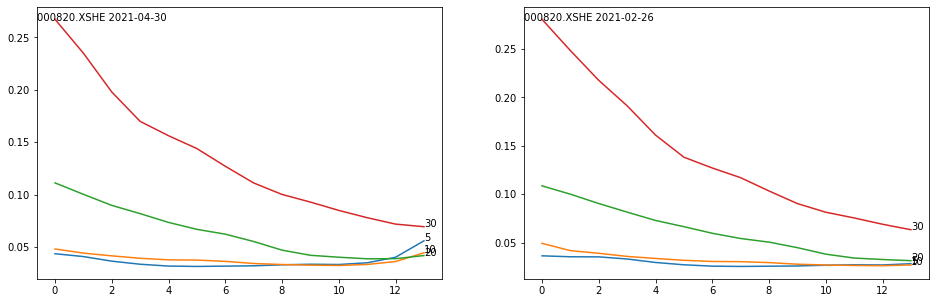

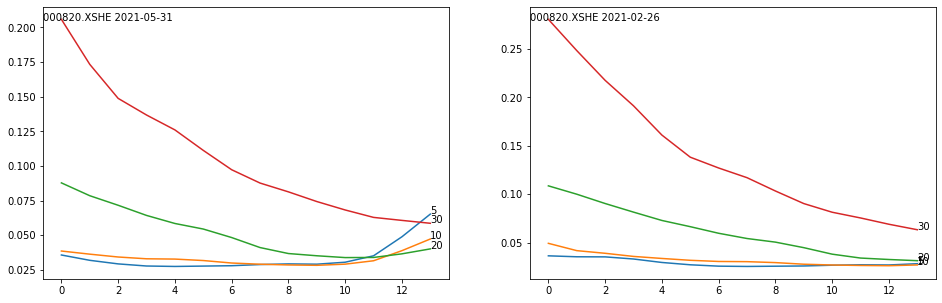

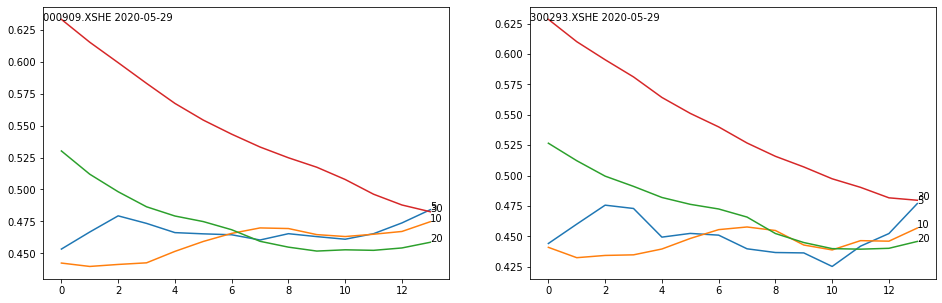

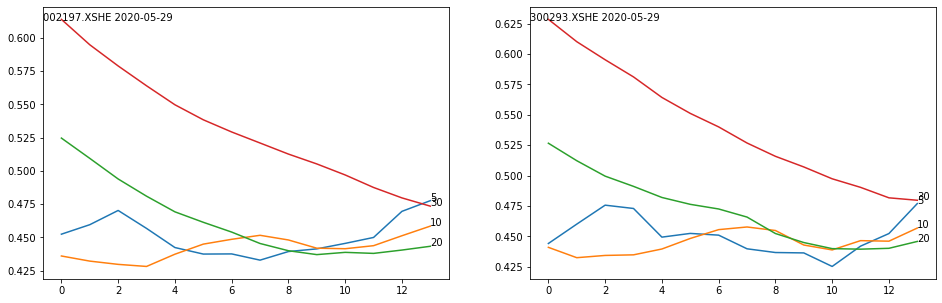

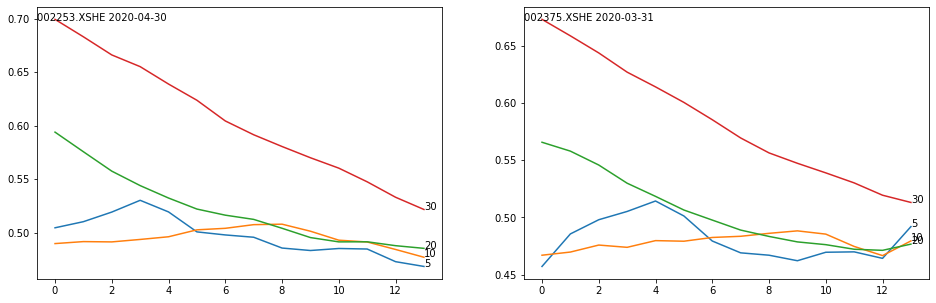

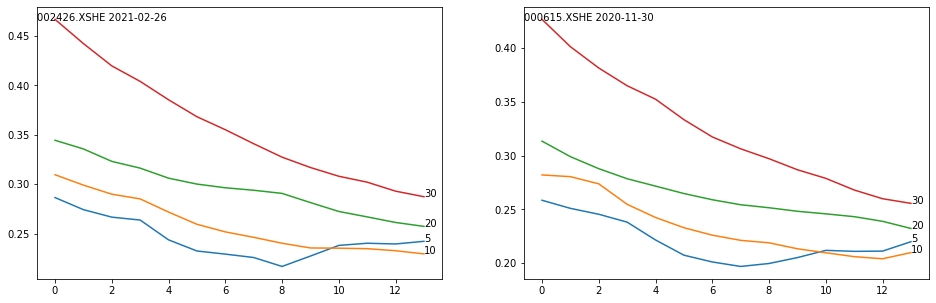

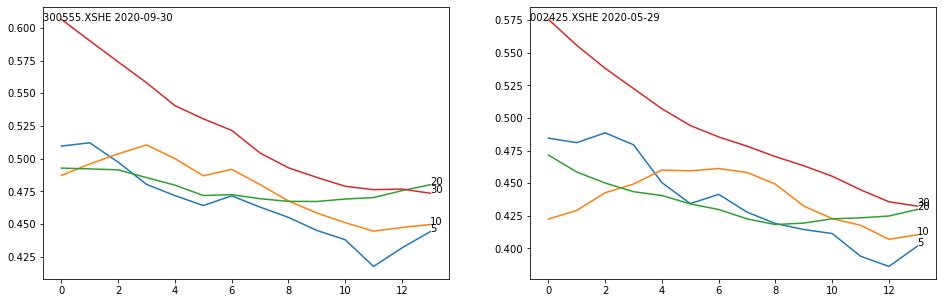

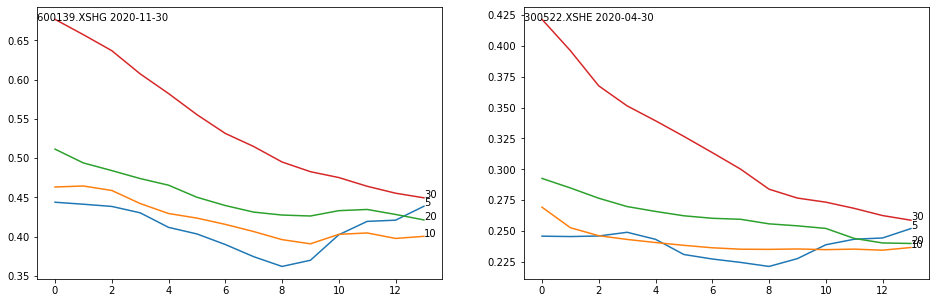

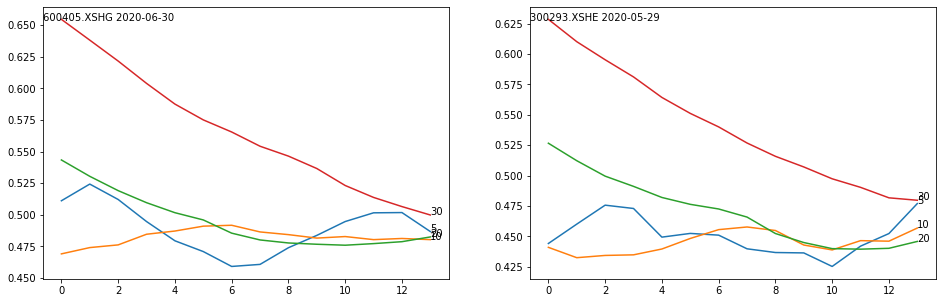

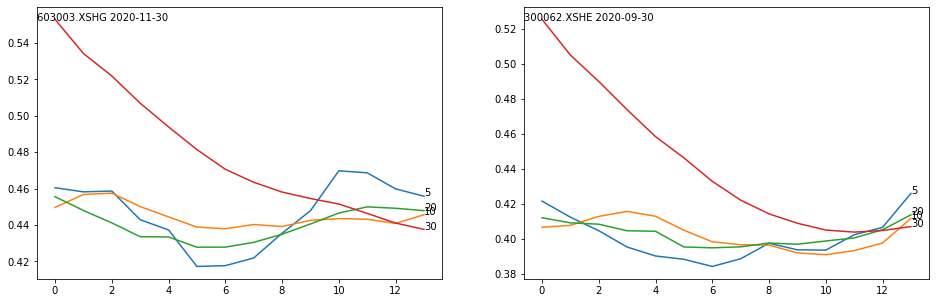

In [505]:
for row in sim_vecs[(sim_vecs.dis > 1e-3) & (sim_vecs.dis<0.07)].to_records():
    _, name1, frame1, name2, frame2, _ = row
    parallel_show(name1, frame1, name2, frame2)

# 月线涨幅大于35%,首月大涨的

In [524]:
for code in choose_stocks():
    bars = get_bars(code, 2, end=None, unit="1M")
    if len(bars) != 2 or bars["date"][1] != datetime.date(2021, 9, 30):
        continue
        
    close = bars["close"]
    adv = close[1]/close[0] - 1
    if 0.25 < adv < 0.4:
        print(get_name(code), code)

粤电力A 000539.XSHE
建投能源 000600.XSHE
新希望 000876.XSHE
湖北能源 000883.XSHE
东方能源 000958.XSHE
蓝焰控股 000968.XSHE
招商积余 001914.XSHE
招商蛇口 001979.XSHE
天润工业 002283.XSHE
杰瑞股份 002353.XSHE
天顺风能 002531.XSHE
洽洽食品 002557.XSHE
凯莱英 002821.XSHE
中国广核 003816.XSHE
奥克股份 300082.XSHE
泰格医药 300347.XSHE
富祥药业 300497.XSHE
贝达药业 300558.XSHE
诚迈科技 300598.XSHE
开立医疗 300633.XSHE
朗新科技 300682.XSHE
壹网壹创 300792.XSHE
中远海能 600026.XSHG
浙江新能 600032.XSHG
广州发展 600098.XSHG
广汇能源 600256.XSHG
安琪酵母 600298.XSHG
平高电气 600312.XSHG
福能股份 600483.XSHG
深高速 600548.XSHG
京能电力 600578.XSHG
氯碱化工 600618.XSHG
川投能源 600674.XSHG
上海石化 600688.XSHG
阳煤化工 600691.XSHG
通策医疗 600763.XSHG
新潮能源 600777.XSHG
国电电力 600795.XSHG
国投电力 600886.XSHG
绿色动力 601330.XSHG
嘉泽新能 601619.XSHG
平煤股份 601666.XSHG
中国电建 601669.XSHG
招商轮船 601872.XSHG
中国核电 601985.XSHG
大唐发电 601991.XSHG
台华新材 603055.XSHG
和邦生物 603077.XSHG
新亚强 603155.XSHG
九洲药业 603456.XSHG
司太立 603520.XSHG
健友股份 603707.XSHG


In [526]:
240 * 250 * 5000/(1000*1000*1000)

0.3

# 月线两连阳

底部启动，月线两连阳

In [538]:
def scan():
    for code in choose_stocks():
        name = get_name(code)
        try:
            bars = get_bars(code, 10, end='2021-09-30', unit='1M')

            c2, c1, c0 = bars["close"][-3:]
            t1 = c0 > c1 and c1 > c2
            t2 = np.all((bars["close"] > bars["open"])[-2:])
            t3 = bars["low"][-3] == np.min(bars["low"])
            t4 = 0.4 > c0 / c1 - 1 > 0.1
            if all([t1, t2, t3, t4]):
                print(name, code)
        except Exception:
            pass
            
scan()

申万宏源 000166.XSHE
中天金融 000540.XSHE
皖能电力 000543.XSHE
建投能源 000600.XSHE
宝新能源 000690.XSHE
登海种业 002041.XSHE
欧菲光 002456.XSHE
申通快递 002468.XSHE
江苏国信 002608.XSHE
中国广核 003816.XSHE
富祥药业 300497.XSHE
温氏股份 300498.XSHE
天宇股份 300702.XSHE
浙能电力 600023.XSHG
国网信通 600131.XSHG
平高电气 600312.XSHG
瀚蓝环境 600323.XSHG
山东黄金 600547.XSHG
京能电力 600578.XSHG
中信重工 601608.XSHG
中国交建 601800.XSHG
